In [20]:
#!pip install numpy==1.19.5
import sys
sys.path.insert(0, '/Volumes/data/LosAlamosSummer')
import Utilities
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import scipy
import kerastuner
print(tf.__version__)
print(kerastuner.__version__)
print(np.__version__)


2.3.0
1.0.2
1.19.5


In [21]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))




In [22]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
    #    print(
    #        "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
    #    )
        return

    def on_test_batch_end(self, batch, logs=None):
     #   print(
     #       "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
     #   )
        return

    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and MAE is {:7.2f}.".format(
                epoch, logs["loss"], logs["MAE"]#logs["mean_squared_logarithmic_error"]
            )
        )


In [23]:
#datapath = '/Users/jessiejo/data/VBUDS/GroupStructurePaper/NeuralNetworks/All_Libraries/NewDataSetFull1.mat'
datapath='/Volumes/data/LosAlamosSummer/GODIVA/GODIVA_data_0_12.mat'
print('Loading In Data')
kinf,GS=Utilities.LoadData(datapath, 0)
#MakeGroupDensity(X, nDecades)
Nfeatures = 1000;


allData= Utilities.ProcessData(datapath, 1,Nfeatures,1,np.linspace(3, 7, Nfeatures),0)
# allData: (100,000x1,000) y_direct: (100,000x3)
print('Finished Loading Data')

Loading In Data
Finished Loading Data



Load Data loads raw data from the .mat file
Inputs
datapath: Path to .mat file containing the data [string]
BU: whether the data contains burnup; 1=burnup, 0=no burnup [bool]

ProcessData is the serialization maker 
Inputs
datapath: Path to .mat file containing the data [string]
Percent of data to be used: in most cases full data set will be used but good for analysis [double](0-1)
ndecades: Number of decades wanted in equal lethargy serialization. Number is ignored if custom serialization inputted [int]
mode: equal lethargy mode (0) or custom serialization mode (1) [boolean]
input serial: a custom serialization regime (ignored if mode is not 1) [numpy array]
BU: whether the data contains burnup; 1=burnup, 0=no burnup [bool]

In [24]:

print(kinf.shape)
print (allData)


(50000,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [25]:
Nsamples,Ndecades = allData.shape
vldF=.1
testF=.2
normConst=np.linalg.norm(kinf)
y_norm=np.array(kinf/normConst)

X, X_test, y, y_test, vldF_corr = Utilities.makeFractions(Nsamples, vldF, testF, allData, y_norm, 0)


NtrainingSamples = int(Nsamples*(1 - testF))
tranValSplit=int(NtrainingSamples*(1-vldF_corr))
X_train=X[:tranValSplit,:]
y_train=y[:tranValSplit]
X_val=X[tranValSplit+1:,:]
y_val=y[tranValSplit+1:]
print(y_test.shape)
print(y_val.shape)
print(y_norm.shape)
print(y_train.shape)

(9999,)
(4999,)
(50000,)
(35000,)


makeFractions splits the data into appropriatly sized sets
Nsamples is the number of samples of the data set
vldF is the validation fraction
testF is the test fraction
allData is the set of serialzed group structures
y_norm is the kinfs that correspond to the serialized group structures (normalized or otherwise)
BU (the last input) is a boolean determining whether the data contains burnup [Boolean] (used in the same manner as previous)

In [26]:

LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (200, 0.0001),
    (400, 0.00001),
    (500, 0.000001),
    (600,0.0000001),
]

def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [27]:
keff_model = tf.keras.Sequential([
    layers.Dense(135, activation='elu', name='hidden_1', input_dim=999),
    layers.Dense(612, activation='elu',  name='hidden_2'),
    layers.Dense(1, activation='linear',name='output')])
keff_model.compile(loss="MAE",optimizer=tf.keras.optimizers.Adam(1e-03),metrics="MAE")#metrics="mean_squared_logarithmic_error")
keff_model.build()
keff_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 135)               135000    
_________________________________________________________________
hidden_2 (Dense)             (None, 612)               83232     
_________________________________________________________________
output (Dense)               (None, 1)                 613       
Total params: 218,845
Trainable params: 218,845
Non-trainable params: 0
_________________________________________________________________


In [28]:
keff_model.fit(X_train,y_train.T, epochs=800, batch_size=2561, verbose=1,shuffle=True,
               callbacks=[LossAndErrorPrintingCallback(),
        CustomLearningRateScheduler(lr_schedule)],validation_data=(X_val,y_val.T))


Epoch 00000: Learning rate is 0.0010.
Epoch 1/800
14/14 [==============================] - 0s 33ms/step - loss: 0.0176 - MAE: 0.0176 - val_loss: 0.0070 - val_MAE: 0.0070

Epoch 00001: Learning rate is 0.0010.
Epoch 2/800
14/14 [==============================] - 0s 24ms/step - loss: 0.0045 - MAE: 0.0045 - val_loss: 0.0033 - val_MAE: 0.0033

Epoch 00002: Learning rate is 0.0010.
Epoch 3/800
14/14 [==============================] - 0s 24ms/step - loss: 0.0028 - MAE: 0.0028 - val_loss: 0.0027 - val_MAE: 0.0027

Epoch 00003: Learning rate is 0.0010.
Epoch 4/800
14/14 [==============================] - 0s 24ms/step - loss: 0.0023 - MAE: 0.0023 - val_loss: 0.0022 - val_MAE: 0.0022

Epoch 00004: Learning rate is 0.0010.
Epoch 5/800
14/14 [==============================] - 0s 24ms/step - loss: 0.0021 - MAE: 0.0021 - val_loss: 0.0022 - val_MAE: 0.0022

Epoch 00005: Learning rate is 0.0010.
Epoch 6/800
14/14 [==============================] - 0s 24ms/step - loss: 0.0021 - MAE: 0.0021 - val_loss:


Epoch 00027: Learning rate is 0.0010.
Epoch 28/800
14/14 [==============================] - 0s 24ms/step - loss: 0.0019 - MAE: 0.0019 - val_loss: 0.0022 - val_MAE: 0.0022

Epoch 00028: Learning rate is 0.0010.
Epoch 29/800
14/14 [==============================] - 0s 23ms/step - loss: 0.0019 - MAE: 0.0019 - val_loss: 0.0017 - val_MAE: 0.0017

Epoch 00029: Learning rate is 0.0010.
Epoch 30/800
14/14 [==============================] - 0s 24ms/step - loss: 0.0019 - MAE: 0.0019 - val_loss: 0.0026 - val_MAE: 0.0026

Epoch 00030: Learning rate is 0.0010.
Epoch 31/800
14/14 [==============================] - 0s 24ms/step - loss: 0.0020 - MAE: 0.0020 - val_loss: 0.0020 - val_MAE: 0.0020

Epoch 00031: Learning rate is 0.0010.
Epoch 32/800
14/14 [==============================] - 0s 24ms/step - loss: 0.0016 - MAE: 0.0016 - val_loss: 0.0018 - val_MAE: 0.0018

Epoch 00032: Learning rate is 0.0010.
Epoch 33/800
14/14 [==============================] - 0s 23ms/step - loss: 0.0014 - MAE: 0.0014 - val

14/14 [==============================] - 0s 24ms/step - loss: 0.0013 - MAE: 0.0013 - val_loss: 0.0017 - val_MAE: 0.0017

Epoch 00054: Learning rate is 0.0010.
Epoch 55/800
14/14 [==============================] - 0s 24ms/step - loss: 0.0014 - MAE: 0.0014 - val_loss: 0.0015 - val_MAE: 0.0015

Epoch 00055: Learning rate is 0.0010.
Epoch 56/800
14/14 [==============================] - 0s 23ms/step - loss: 0.0014 - MAE: 0.0014 - val_loss: 0.0013 - val_MAE: 0.0013

Epoch 00056: Learning rate is 0.0010.
Epoch 57/800
14/14 [==============================] - 0s 24ms/step - loss: 0.0011 - MAE: 0.0011 - val_loss: 0.0011 - val_MAE: 0.0011

Epoch 00057: Learning rate is 0.0010.
Epoch 58/800
14/14 [==============================] - 0s 24ms/step - loss: 8.9036e-04 - MAE: 8.9036e-04 - val_loss: 8.0446e-04 - val_MAE: 8.0446e-04

Epoch 00058: Learning rate is 0.0010.
Epoch 59/800
14/14 [==============================] - 0s 23ms/step - loss: 8.3300e-04 - MAE: 8.3300e-04 - val_loss: 7.2959e-04 - val_MAE:


Epoch 00079: Learning rate is 0.0010.
Epoch 80/800
14/14 [==============================] - 0s 23ms/step - loss: 9.6436e-04 - MAE: 9.6436e-04 - val_loss: 0.0010 - val_MAE: 0.0010

Epoch 00080: Learning rate is 0.0010.
Epoch 81/800
14/14 [==============================] - 0s 23ms/step - loss: 8.9925e-04 - MAE: 8.9925e-04 - val_loss: 0.0010 - val_MAE: 0.0010

Epoch 00081: Learning rate is 0.0010.
Epoch 82/800
14/14 [==============================] - 0s 24ms/step - loss: 9.1074e-04 - MAE: 9.1074e-04 - val_loss: 9.0048e-04 - val_MAE: 9.0048e-04

Epoch 00082: Learning rate is 0.0010.
Epoch 83/800
14/14 [==============================] - 0s 24ms/step - loss: 7.7558e-04 - MAE: 7.7558e-04 - val_loss: 6.9851e-04 - val_MAE: 6.9851e-04

Epoch 00083: Learning rate is 0.0010.
Epoch 84/800
14/14 [==============================] - 0s 24ms/step - loss: 8.9164e-04 - MAE: 8.9164e-04 - val_loss: 0.0010 - val_MAE: 0.0010

Epoch 00084: Learning rate is 0.0010.
Epoch 85/800
14/14 [=========================


Epoch 00104: Learning rate is 0.0010.
Epoch 105/800
14/14 [==============================] - 0s 24ms/step - loss: 6.5849e-04 - MAE: 6.5849e-04 - val_loss: 8.8005e-04 - val_MAE: 8.8005e-04

Epoch 00105: Learning rate is 0.0010.
Epoch 106/800
14/14 [==============================] - 0s 24ms/step - loss: 6.9188e-04 - MAE: 6.9188e-04 - val_loss: 4.6590e-04 - val_MAE: 4.6590e-04

Epoch 00106: Learning rate is 0.0010.
Epoch 107/800
14/14 [==============================] - 0s 24ms/step - loss: 6.3846e-04 - MAE: 6.3846e-04 - val_loss: 5.9640e-04 - val_MAE: 5.9640e-04

Epoch 00107: Learning rate is 0.0010.
Epoch 108/800
14/14 [==============================] - 0s 24ms/step - loss: 6.3827e-04 - MAE: 6.3827e-04 - val_loss: 5.6283e-04 - val_MAE: 5.6283e-04

Epoch 00108: Learning rate is 0.0010.
Epoch 109/800
14/14 [==============================] - 0s 24ms/step - loss: 6.3898e-04 - MAE: 6.3898e-04 - val_loss: 8.7396e-04 - val_MAE: 8.7396e-04

Epoch 00109: Learning rate is 0.0010.
Epoch 110/800
14

14/14 [==============================] - 0s 24ms/step - loss: 4.6179e-04 - MAE: 4.6179e-04 - val_loss: 4.5828e-04 - val_MAE: 4.5828e-04

Epoch 00129: Learning rate is 0.0010.
Epoch 130/800
14/14 [==============================] - 0s 24ms/step - loss: 4.4640e-04 - MAE: 4.4640e-04 - val_loss: 5.2924e-04 - val_MAE: 5.2924e-04

Epoch 00130: Learning rate is 0.0010.
Epoch 131/800
14/14 [==============================] - 0s 23ms/step - loss: 4.4927e-04 - MAE: 4.4927e-04 - val_loss: 3.6301e-04 - val_MAE: 3.6301e-04

Epoch 00131: Learning rate is 0.0010.
Epoch 132/800
14/14 [==============================] - 0s 24ms/step - loss: 4.6456e-04 - MAE: 4.6456e-04 - val_loss: 3.6623e-04 - val_MAE: 3.6623e-04

Epoch 00132: Learning rate is 0.0010.
Epoch 133/800
14/14 [==============================] - 0s 24ms/step - loss: 4.5088e-04 - MAE: 4.5088e-04 - val_loss: 3.7256e-04 - val_MAE: 3.7256e-04

Epoch 00133: Learning rate is 0.0010.
Epoch 134/800
14/14 [==============================] - 0s 24ms/step -


Epoch 00153: Learning rate is 0.0010.
Epoch 154/800
14/14 [==============================] - 0s 25ms/step - loss: 3.5324e-04 - MAE: 3.5324e-04 - val_loss: 4.8769e-04 - val_MAE: 4.8769e-04

Epoch 00154: Learning rate is 0.0010.
Epoch 155/800
14/14 [==============================] - 0s 24ms/step - loss: 3.5739e-04 - MAE: 3.5739e-04 - val_loss: 2.5340e-04 - val_MAE: 2.5340e-04

Epoch 00155: Learning rate is 0.0010.
Epoch 156/800
14/14 [==============================] - 0s 24ms/step - loss: 3.5320e-04 - MAE: 3.5320e-04 - val_loss: 2.0976e-04 - val_MAE: 2.0976e-04

Epoch 00156: Learning rate is 0.0010.
Epoch 157/800
14/14 [==============================] - 0s 24ms/step - loss: 3.1000e-04 - MAE: 3.1000e-04 - val_loss: 4.6787e-04 - val_MAE: 4.6787e-04

Epoch 00157: Learning rate is 0.0010.
Epoch 158/800
14/14 [==============================] - 0s 24ms/step - loss: 3.4015e-04 - MAE: 3.4015e-04 - val_loss: 2.3412e-04 - val_MAE: 2.3412e-04

Epoch 00158: Learning rate is 0.0010.
Epoch 159/800
14

14/14 [==============================] - 0s 21ms/step - loss: 3.5407e-04 - MAE: 3.5407e-04 - val_loss: 3.8022e-04 - val_MAE: 3.8022e-04

Epoch 00178: Learning rate is 0.0010.
Epoch 179/800
14/14 [==============================] - 0s 22ms/step - loss: 3.5006e-04 - MAE: 3.5006e-04 - val_loss: 3.4755e-04 - val_MAE: 3.4755e-04

Epoch 00179: Learning rate is 0.0010.
Epoch 180/800
14/14 [==============================] - 0s 22ms/step - loss: 3.4659e-04 - MAE: 3.4659e-04 - val_loss: 3.6369e-04 - val_MAE: 3.6369e-04

Epoch 00180: Learning rate is 0.0010.
Epoch 181/800
14/14 [==============================] - 0s 21ms/step - loss: 3.2832e-04 - MAE: 3.2832e-04 - val_loss: 3.9106e-04 - val_MAE: 3.9106e-04

Epoch 00181: Learning rate is 0.0010.
Epoch 182/800
14/14 [==============================] - 0s 21ms/step - loss: 3.4026e-04 - MAE: 3.4026e-04 - val_loss: 3.1830e-04 - val_MAE: 3.1830e-04

Epoch 00182: Learning rate is 0.0010.
Epoch 183/800
14/14 [==============================] - 0s 22ms/step -


Epoch 00202: Learning rate is 0.0001.
Epoch 203/800
14/14 [==============================] - 0s 23ms/step - loss: 1.0661e-04 - MAE: 1.0661e-04 - val_loss: 1.1520e-04 - val_MAE: 1.1520e-04

Epoch 00203: Learning rate is 0.0001.
Epoch 204/800
14/14 [==============================] - 0s 24ms/step - loss: 1.0603e-04 - MAE: 1.0603e-04 - val_loss: 1.1535e-04 - val_MAE: 1.1535e-04

Epoch 00204: Learning rate is 0.0001.
Epoch 205/800
14/14 [==============================] - 0s 24ms/step - loss: 1.0603e-04 - MAE: 1.0603e-04 - val_loss: 1.1528e-04 - val_MAE: 1.1528e-04

Epoch 00205: Learning rate is 0.0001.
Epoch 206/800
14/14 [==============================] - 0s 24ms/step - loss: 1.0602e-04 - MAE: 1.0602e-04 - val_loss: 1.1542e-04 - val_MAE: 1.1542e-04

Epoch 00206: Learning rate is 0.0001.
Epoch 207/800
14/14 [==============================] - 0s 23ms/step - loss: 1.0554e-04 - MAE: 1.0554e-04 - val_loss: 1.1527e-04 - val_MAE: 1.1527e-04

Epoch 00207: Learning rate is 0.0001.
Epoch 208/800
14

14/14 [==============================] - 0s 24ms/step - loss: 1.0174e-04 - MAE: 1.0174e-04 - val_loss: 1.1296e-04 - val_MAE: 1.1296e-04

Epoch 00227: Learning rate is 0.0001.
Epoch 228/800
14/14 [==============================] - 0s 24ms/step - loss: 1.0179e-04 - MAE: 1.0179e-04 - val_loss: 1.1258e-04 - val_MAE: 1.1258e-04

Epoch 00228: Learning rate is 0.0001.
Epoch 229/800
14/14 [==============================] - 0s 23ms/step - loss: 1.0135e-04 - MAE: 1.0135e-04 - val_loss: 1.1199e-04 - val_MAE: 1.1199e-04

Epoch 00229: Learning rate is 0.0001.
Epoch 230/800
14/14 [==============================] - 0s 24ms/step - loss: 1.0106e-04 - MAE: 1.0106e-04 - val_loss: 1.1216e-04 - val_MAE: 1.1216e-04

Epoch 00230: Learning rate is 0.0001.
Epoch 231/800
14/14 [==============================] - 0s 24ms/step - loss: 1.0122e-04 - MAE: 1.0122e-04 - val_loss: 1.1237e-04 - val_MAE: 1.1237e-04

Epoch 00231: Learning rate is 0.0001.
Epoch 232/800
14/14 [==============================] - 0s 24ms/step -


Epoch 00251: Learning rate is 0.0001.
Epoch 252/800
14/14 [==============================] - 0s 24ms/step - loss: 9.5569e-05 - MAE: 9.5569e-05 - val_loss: 1.0873e-04 - val_MAE: 1.0873e-04

Epoch 00252: Learning rate is 0.0001.
Epoch 253/800
14/14 [==============================] - 0s 24ms/step - loss: 9.5504e-05 - MAE: 9.5504e-05 - val_loss: 1.0820e-04 - val_MAE: 1.0820e-04

Epoch 00253: Learning rate is 0.0001.
Epoch 254/800
14/14 [==============================] - 0s 24ms/step - loss: 9.4724e-05 - MAE: 9.4724e-05 - val_loss: 1.0701e-04 - val_MAE: 1.0701e-04

Epoch 00254: Learning rate is 0.0001.
Epoch 255/800
14/14 [==============================] - 0s 24ms/step - loss: 9.4463e-05 - MAE: 9.4463e-05 - val_loss: 1.0764e-04 - val_MAE: 1.0764e-04

Epoch 00255: Learning rate is 0.0001.
Epoch 256/800
14/14 [==============================] - 0s 24ms/step - loss: 9.4770e-05 - MAE: 9.4770e-05 - val_loss: 1.0872e-04 - val_MAE: 1.0872e-04

Epoch 00256: Learning rate is 0.0001.
Epoch 257/800
14

14/14 [==============================] - 0s 25ms/step - loss: 9.5522e-05 - MAE: 9.5522e-05 - val_loss: 1.0853e-04 - val_MAE: 1.0853e-04

Epoch 00276: Learning rate is 0.0001.
Epoch 277/800
14/14 [==============================] - 0s 24ms/step - loss: 9.5612e-05 - MAE: 9.5612e-05 - val_loss: 1.0486e-04 - val_MAE: 1.0486e-04

Epoch 00277: Learning rate is 0.0001.
Epoch 278/800
14/14 [==============================] - 0s 24ms/step - loss: 9.4818e-05 - MAE: 9.4818e-05 - val_loss: 1.0659e-04 - val_MAE: 1.0659e-04

Epoch 00278: Learning rate is 0.0001.
Epoch 279/800
14/14 [==============================] - 0s 24ms/step - loss: 9.3811e-05 - MAE: 9.3811e-05 - val_loss: 1.0719e-04 - val_MAE: 1.0719e-04

Epoch 00279: Learning rate is 0.0001.
Epoch 280/800
14/14 [==============================] - 0s 24ms/step - loss: 9.3636e-05 - MAE: 9.3636e-05 - val_loss: 1.0711e-04 - val_MAE: 1.0711e-04

Epoch 00280: Learning rate is 0.0001.
Epoch 281/800
14/14 [==============================] - 0s 24ms/step -


Epoch 00300: Learning rate is 0.0001.
Epoch 301/800
14/14 [==============================] - 0s 25ms/step - loss: 9.0062e-05 - MAE: 9.0062e-05 - val_loss: 1.0109e-04 - val_MAE: 1.0109e-04

Epoch 00301: Learning rate is 0.0001.
Epoch 302/800
14/14 [==============================] - 0s 26ms/step - loss: 9.0958e-05 - MAE: 9.0958e-05 - val_loss: 1.0532e-04 - val_MAE: 1.0532e-04

Epoch 00302: Learning rate is 0.0001.
Epoch 303/800
14/14 [==============================] - 0s 25ms/step - loss: 9.0809e-05 - MAE: 9.0809e-05 - val_loss: 1.0279e-04 - val_MAE: 1.0279e-04

Epoch 00303: Learning rate is 0.0001.
Epoch 304/800
14/14 [==============================] - 0s 26ms/step - loss: 9.1931e-05 - MAE: 9.1931e-05 - val_loss: 1.0017e-04 - val_MAE: 1.0017e-04

Epoch 00304: Learning rate is 0.0001.
Epoch 305/800
14/14 [==============================] - 0s 26ms/step - loss: 9.3826e-05 - MAE: 9.3826e-05 - val_loss: 1.0787e-04 - val_MAE: 1.0787e-04

Epoch 00305: Learning rate is 0.0001.
Epoch 306/800
14

14/14 [==============================] - 0s 24ms/step - loss: 8.8045e-05 - MAE: 8.8045e-05 - val_loss: 1.0742e-04 - val_MAE: 1.0742e-04

Epoch 00325: Learning rate is 0.0001.
Epoch 326/800
14/14 [==============================] - 0s 24ms/step - loss: 8.8104e-05 - MAE: 8.8104e-05 - val_loss: 1.0147e-04 - val_MAE: 1.0147e-04

Epoch 00326: Learning rate is 0.0001.
Epoch 327/800
14/14 [==============================] - 0s 24ms/step - loss: 8.8493e-05 - MAE: 8.8493e-05 - val_loss: 1.1152e-04 - val_MAE: 1.1152e-04

Epoch 00327: Learning rate is 0.0001.
Epoch 328/800
14/14 [==============================] - 0s 23ms/step - loss: 9.7410e-05 - MAE: 9.7410e-05 - val_loss: 1.1638e-04 - val_MAE: 1.1638e-04

Epoch 00328: Learning rate is 0.0001.
Epoch 329/800
14/14 [==============================] - 0s 24ms/step - loss: 9.1073e-05 - MAE: 9.1073e-05 - val_loss: 1.0455e-04 - val_MAE: 1.0455e-04

Epoch 00329: Learning rate is 0.0001.
Epoch 330/800
14/14 [==============================] - 0s 24ms/step -


Epoch 00349: Learning rate is 0.0001.
Epoch 350/800
14/14 [==============================] - 0s 24ms/step - loss: 1.2042e-04 - MAE: 1.2042e-04 - val_loss: 1.2143e-04 - val_MAE: 1.2143e-04

Epoch 00350: Learning rate is 0.0001.
Epoch 351/800
14/14 [==============================] - 0s 24ms/step - loss: 9.8816e-05 - MAE: 9.8816e-05 - val_loss: 1.1564e-04 - val_MAE: 1.1564e-04

Epoch 00351: Learning rate is 0.0001.
Epoch 352/800
14/14 [==============================] - 0s 23ms/step - loss: 9.6977e-05 - MAE: 9.6977e-05 - val_loss: 1.0126e-04 - val_MAE: 1.0126e-04

Epoch 00352: Learning rate is 0.0001.
Epoch 353/800
14/14 [==============================] - 0s 24ms/step - loss: 8.6255e-05 - MAE: 8.6255e-05 - val_loss: 9.9362e-05 - val_MAE: 9.9362e-05

Epoch 00353: Learning rate is 0.0001.
Epoch 354/800
14/14 [==============================] - 0s 24ms/step - loss: 8.1119e-05 - MAE: 8.1119e-05 - val_loss: 9.8124e-05 - val_MAE: 9.8124e-05

Epoch 00354: Learning rate is 0.0001.
Epoch 355/800
14

14/14 [==============================] - 0s 24ms/step - loss: 7.9812e-05 - MAE: 7.9812e-05 - val_loss: 1.0564e-04 - val_MAE: 1.0564e-04

Epoch 00374: Learning rate is 0.0001.
Epoch 375/800
14/14 [==============================] - 0s 24ms/step - loss: 8.5275e-05 - MAE: 8.5275e-05 - val_loss: 1.0566e-04 - val_MAE: 1.0566e-04

Epoch 00375: Learning rate is 0.0001.
Epoch 376/800
14/14 [==============================] - 0s 24ms/step - loss: 8.3859e-05 - MAE: 8.3859e-05 - val_loss: 9.7663e-05 - val_MAE: 9.7663e-05

Epoch 00376: Learning rate is 0.0001.
Epoch 377/800
14/14 [==============================] - 0s 24ms/step - loss: 8.4356e-05 - MAE: 8.4356e-05 - val_loss: 9.9273e-05 - val_MAE: 9.9273e-05

Epoch 00377: Learning rate is 0.0001.
Epoch 378/800
14/14 [==============================] - 0s 24ms/step - loss: 8.2354e-05 - MAE: 8.2354e-05 - val_loss: 1.0249e-04 - val_MAE: 1.0249e-04

Epoch 00378: Learning rate is 0.0001.
Epoch 379/800
14/14 [==============================] - 0s 24ms/step -


Epoch 00398: Learning rate is 0.0001.
Epoch 399/800
14/14 [==============================] - 0s 26ms/step - loss: 8.2170e-05 - MAE: 8.2170e-05 - val_loss: 1.0458e-04 - val_MAE: 1.0458e-04

Epoch 00399: Learning rate is 0.0001.
Epoch 400/800
14/14 [==============================] - 0s 24ms/step - loss: 8.2368e-05 - MAE: 8.2368e-05 - val_loss: 1.1088e-04 - val_MAE: 1.1088e-04

Epoch 00400: Learning rate is 0.0000.
Epoch 401/800
14/14 [==============================] - 0s 25ms/step - loss: 8.0497e-05 - MAE: 8.0497e-05 - val_loss: 9.3704e-05 - val_MAE: 9.3704e-05

Epoch 00401: Learning rate is 0.0000.
Epoch 402/800
14/14 [==============================] - 0s 24ms/step - loss: 7.0953e-05 - MAE: 7.0953e-05 - val_loss: 9.3667e-05 - val_MAE: 9.3667e-05

Epoch 00402: Learning rate is 0.0000.
Epoch 403/800
14/14 [==============================] - 0s 24ms/step - loss: 6.9086e-05 - MAE: 6.9086e-05 - val_loss: 9.4254e-05 - val_MAE: 9.4254e-05

Epoch 00403: Learning rate is 0.0000.
Epoch 404/800
14

14/14 [==============================] - 0s 24ms/step - loss: 6.7496e-05 - MAE: 6.7496e-05 - val_loss: 9.3403e-05 - val_MAE: 9.3403e-05

Epoch 00423: Learning rate is 0.0000.
Epoch 424/800
14/14 [==============================] - 0s 24ms/step - loss: 6.7408e-05 - MAE: 6.7408e-05 - val_loss: 9.3250e-05 - val_MAE: 9.3250e-05

Epoch 00424: Learning rate is 0.0000.
Epoch 425/800
14/14 [==============================] - 0s 25ms/step - loss: 6.7385e-05 - MAE: 6.7385e-05 - val_loss: 9.3209e-05 - val_MAE: 9.3209e-05

Epoch 00425: Learning rate is 0.0000.
Epoch 426/800
14/14 [==============================] - 0s 24ms/step - loss: 6.7417e-05 - MAE: 6.7417e-05 - val_loss: 9.3126e-05 - val_MAE: 9.3126e-05

Epoch 00426: Learning rate is 0.0000.
Epoch 427/800
14/14 [==============================] - 0s 24ms/step - loss: 6.7326e-05 - MAE: 6.7326e-05 - val_loss: 9.3178e-05 - val_MAE: 9.3178e-05

Epoch 00427: Learning rate is 0.0000.
Epoch 428/800
14/14 [==============================] - 0s 24ms/step -


Epoch 00447: Learning rate is 0.0000.
Epoch 448/800
14/14 [==============================] - 0s 24ms/step - loss: 6.6297e-05 - MAE: 6.6297e-05 - val_loss: 9.2956e-05 - val_MAE: 9.2956e-05

Epoch 00448: Learning rate is 0.0000.
Epoch 449/800
14/14 [==============================] - 0s 24ms/step - loss: 6.6338e-05 - MAE: 6.6338e-05 - val_loss: 9.2708e-05 - val_MAE: 9.2708e-05

Epoch 00449: Learning rate is 0.0000.
Epoch 450/800
14/14 [==============================] - 0s 24ms/step - loss: 6.6271e-05 - MAE: 6.6271e-05 - val_loss: 9.2558e-05 - val_MAE: 9.2558e-05

Epoch 00450: Learning rate is 0.0000.
Epoch 451/800
14/14 [==============================] - 0s 25ms/step - loss: 6.6155e-05 - MAE: 6.6155e-05 - val_loss: 9.2754e-05 - val_MAE: 9.2754e-05

Epoch 00451: Learning rate is 0.0000.
Epoch 452/800
14/14 [==============================] - 0s 24ms/step - loss: 6.6129e-05 - MAE: 6.6129e-05 - val_loss: 9.2650e-05 - val_MAE: 9.2650e-05

Epoch 00452: Learning rate is 0.0000.
Epoch 453/800
14

14/14 [==============================] - 0s 24ms/step - loss: 6.5205e-05 - MAE: 6.5205e-05 - val_loss: 9.2399e-05 - val_MAE: 9.2399e-05

Epoch 00472: Learning rate is 0.0000.
Epoch 473/800
14/14 [==============================] - 0s 28ms/step - loss: 6.5302e-05 - MAE: 6.5302e-05 - val_loss: 9.2347e-05 - val_MAE: 9.2347e-05

Epoch 00473: Learning rate is 0.0000.
Epoch 474/800
14/14 [==============================] - 0s 28ms/step - loss: 6.5220e-05 - MAE: 6.5220e-05 - val_loss: 9.2281e-05 - val_MAE: 9.2281e-05

Epoch 00474: Learning rate is 0.0000.
Epoch 475/800
14/14 [==============================] - 0s 24ms/step - loss: 6.5312e-05 - MAE: 6.5312e-05 - val_loss: 9.2344e-05 - val_MAE: 9.2344e-05

Epoch 00475: Learning rate is 0.0000.
Epoch 476/800
14/14 [==============================] - 0s 23ms/step - loss: 6.5153e-05 - MAE: 6.5153e-05 - val_loss: 9.2022e-05 - val_MAE: 9.2022e-05

Epoch 00476: Learning rate is 0.0000.
Epoch 477/800
14/14 [==============================] - 0s 24ms/step -


Epoch 00496: Learning rate is 0.0000.
Epoch 497/800
14/14 [==============================] - 0s 24ms/step - loss: 6.4343e-05 - MAE: 6.4343e-05 - val_loss: 9.1695e-05 - val_MAE: 9.1695e-05

Epoch 00497: Learning rate is 0.0000.
Epoch 498/800
14/14 [==============================] - 0s 24ms/step - loss: 6.4256e-05 - MAE: 6.4256e-05 - val_loss: 9.1746e-05 - val_MAE: 9.1746e-05

Epoch 00498: Learning rate is 0.0000.
Epoch 499/800
14/14 [==============================] - 0s 25ms/step - loss: 6.4184e-05 - MAE: 6.4184e-05 - val_loss: 9.1569e-05 - val_MAE: 9.1569e-05

Epoch 00499: Learning rate is 0.0000.
Epoch 500/800
14/14 [==============================] - 0s 24ms/step - loss: 6.4179e-05 - MAE: 6.4179e-05 - val_loss: 9.1658e-05 - val_MAE: 9.1658e-05

Epoch 00500: Learning rate is 0.0000.
Epoch 501/800
14/14 [==============================] - 0s 24ms/step - loss: 6.3716e-05 - MAE: 6.3716e-05 - val_loss: 9.1584e-05 - val_MAE: 9.1584e-05

Epoch 00501: Learning rate is 0.0000.
Epoch 502/800
14

14/14 [==============================] - 0s 25ms/step - loss: 6.3307e-05 - MAE: 6.3307e-05 - val_loss: 9.1564e-05 - val_MAE: 9.1564e-05

Epoch 00521: Learning rate is 0.0000.
Epoch 522/800
14/14 [==============================] - 0s 24ms/step - loss: 6.3291e-05 - MAE: 6.3291e-05 - val_loss: 9.1566e-05 - val_MAE: 9.1566e-05

Epoch 00522: Learning rate is 0.0000.
Epoch 523/800
14/14 [==============================] - 0s 24ms/step - loss: 6.3292e-05 - MAE: 6.3292e-05 - val_loss: 9.1586e-05 - val_MAE: 9.1586e-05

Epoch 00523: Learning rate is 0.0000.
Epoch 524/800
14/14 [==============================] - 0s 24ms/step - loss: 6.3285e-05 - MAE: 6.3285e-05 - val_loss: 9.1610e-05 - val_MAE: 9.1610e-05

Epoch 00524: Learning rate is 0.0000.
Epoch 525/800
14/14 [==============================] - 0s 24ms/step - loss: 6.3283e-05 - MAE: 6.3283e-05 - val_loss: 9.1646e-05 - val_MAE: 9.1646e-05

Epoch 00525: Learning rate is 0.0000.
Epoch 526/800
14/14 [==============================] - 0s 24ms/step -


Epoch 00545: Learning rate is 0.0000.
Epoch 546/800
14/14 [==============================] - 0s 24ms/step - loss: 6.3151e-05 - MAE: 6.3151e-05 - val_loss: 9.1515e-05 - val_MAE: 9.1515e-05

Epoch 00546: Learning rate is 0.0000.
Epoch 547/800
14/14 [==============================] - 0s 25ms/step - loss: 6.3130e-05 - MAE: 6.3130e-05 - val_loss: 9.1599e-05 - val_MAE: 9.1599e-05

Epoch 00547: Learning rate is 0.0000.
Epoch 548/800
14/14 [==============================] - 0s 24ms/step - loss: 6.3135e-05 - MAE: 6.3135e-05 - val_loss: 9.1606e-05 - val_MAE: 9.1606e-05

Epoch 00548: Learning rate is 0.0000.
Epoch 549/800
14/14 [==============================] - 0s 27ms/step - loss: 6.3138e-05 - MAE: 6.3138e-05 - val_loss: 9.1546e-05 - val_MAE: 9.1546e-05

Epoch 00549: Learning rate is 0.0000.
Epoch 550/800
14/14 [==============================] - 0s 25ms/step - loss: 6.3123e-05 - MAE: 6.3123e-05 - val_loss: 9.1439e-05 - val_MAE: 9.1439e-05

Epoch 00550: Learning rate is 0.0000.
Epoch 551/800
14

14/14 [==============================] - 0s 24ms/step - loss: 6.3000e-05 - MAE: 6.3000e-05 - val_loss: 9.1505e-05 - val_MAE: 9.1505e-05

Epoch 00570: Learning rate is 0.0000.
Epoch 571/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2987e-05 - MAE: 6.2987e-05 - val_loss: 9.1561e-05 - val_MAE: 9.1561e-05

Epoch 00571: Learning rate is 0.0000.
Epoch 572/800
14/14 [==============================] - 0s 23ms/step - loss: 6.2973e-05 - MAE: 6.2973e-05 - val_loss: 9.1397e-05 - val_MAE: 9.1397e-05

Epoch 00572: Learning rate is 0.0000.
Epoch 573/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2967e-05 - MAE: 6.2967e-05 - val_loss: 9.1533e-05 - val_MAE: 9.1533e-05

Epoch 00573: Learning rate is 0.0000.
Epoch 574/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2948e-05 - MAE: 6.2948e-05 - val_loss: 9.1480e-05 - val_MAE: 9.1480e-05

Epoch 00574: Learning rate is 0.0000.
Epoch 575/800
14/14 [==============================] - 0s 24ms/step -


Epoch 00594: Learning rate is 0.0000.
Epoch 595/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2802e-05 - MAE: 6.2802e-05 - val_loss: 9.1403e-05 - val_MAE: 9.1403e-05

Epoch 00595: Learning rate is 0.0000.
Epoch 596/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2796e-05 - MAE: 6.2796e-05 - val_loss: 9.1549e-05 - val_MAE: 9.1549e-05

Epoch 00596: Learning rate is 0.0000.
Epoch 597/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2796e-05 - MAE: 6.2796e-05 - val_loss: 9.1446e-05 - val_MAE: 9.1446e-05

Epoch 00597: Learning rate is 0.0000.
Epoch 598/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2774e-05 - MAE: 6.2774e-05 - val_loss: 9.1399e-05 - val_MAE: 9.1399e-05

Epoch 00598: Learning rate is 0.0000.
Epoch 599/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2779e-05 - MAE: 6.2779e-05 - val_loss: 9.1427e-05 - val_MAE: 9.1427e-05

Epoch 00599: Learning rate is 0.0000.
Epoch 600/800
14

14/14 [==============================] - 0s 24ms/step - loss: 6.2670e-05 - MAE: 6.2670e-05 - val_loss: 9.1441e-05 - val_MAE: 9.1441e-05

Epoch 00619: Learning rate is 0.0000.
Epoch 620/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2668e-05 - MAE: 6.2668e-05 - val_loss: 9.1435e-05 - val_MAE: 9.1435e-05

Epoch 00620: Learning rate is 0.0000.
Epoch 621/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2667e-05 - MAE: 6.2667e-05 - val_loss: 9.1440e-05 - val_MAE: 9.1440e-05

Epoch 00621: Learning rate is 0.0000.
Epoch 622/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2667e-05 - MAE: 6.2667e-05 - val_loss: 9.1428e-05 - val_MAE: 9.1428e-05

Epoch 00622: Learning rate is 0.0000.
Epoch 623/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2667e-05 - MAE: 6.2667e-05 - val_loss: 9.1442e-05 - val_MAE: 9.1442e-05

Epoch 00623: Learning rate is 0.0000.
Epoch 624/800
14/14 [==============================] - 0s 24ms/step -


Epoch 00643: Learning rate is 0.0000.
Epoch 644/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2646e-05 - MAE: 6.2646e-05 - val_loss: 9.1438e-05 - val_MAE: 9.1438e-05

Epoch 00644: Learning rate is 0.0000.
Epoch 645/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2648e-05 - MAE: 6.2648e-05 - val_loss: 9.1439e-05 - val_MAE: 9.1439e-05

Epoch 00645: Learning rate is 0.0000.
Epoch 646/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2647e-05 - MAE: 6.2647e-05 - val_loss: 9.1430e-05 - val_MAE: 9.1430e-05

Epoch 00646: Learning rate is 0.0000.
Epoch 647/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2648e-05 - MAE: 6.2648e-05 - val_loss: 9.1437e-05 - val_MAE: 9.1437e-05

Epoch 00647: Learning rate is 0.0000.
Epoch 648/800
14/14 [==============================] - 0s 25ms/step - loss: 6.2642e-05 - MAE: 6.2642e-05 - val_loss: 9.1432e-05 - val_MAE: 9.1432e-05

Epoch 00648: Learning rate is 0.0000.
Epoch 649/800
14

14/14 [==============================] - 0s 26ms/step - loss: 6.2625e-05 - MAE: 6.2625e-05 - val_loss: 9.1428e-05 - val_MAE: 9.1428e-05

Epoch 00668: Learning rate is 0.0000.
Epoch 669/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2624e-05 - MAE: 6.2624e-05 - val_loss: 9.1431e-05 - val_MAE: 9.1431e-05

Epoch 00669: Learning rate is 0.0000.
Epoch 670/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2624e-05 - MAE: 6.2624e-05 - val_loss: 9.1429e-05 - val_MAE: 9.1429e-05

Epoch 00670: Learning rate is 0.0000.
Epoch 671/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2624e-05 - MAE: 6.2624e-05 - val_loss: 9.1412e-05 - val_MAE: 9.1412e-05

Epoch 00671: Learning rate is 0.0000.
Epoch 672/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2621e-05 - MAE: 6.2621e-05 - val_loss: 9.1444e-05 - val_MAE: 9.1444e-05

Epoch 00672: Learning rate is 0.0000.
Epoch 673/800
14/14 [==============================] - 0s 25ms/step -


Epoch 00692: Learning rate is 0.0000.
Epoch 693/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2602e-05 - MAE: 6.2602e-05 - val_loss: 9.1415e-05 - val_MAE: 9.1415e-05

Epoch 00693: Learning rate is 0.0000.
Epoch 694/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2600e-05 - MAE: 6.2600e-05 - val_loss: 9.1433e-05 - val_MAE: 9.1433e-05

Epoch 00694: Learning rate is 0.0000.
Epoch 695/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2605e-05 - MAE: 6.2605e-05 - val_loss: 9.1437e-05 - val_MAE: 9.1437e-05

Epoch 00695: Learning rate is 0.0000.
Epoch 696/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2603e-05 - MAE: 6.2603e-05 - val_loss: 9.1407e-05 - val_MAE: 9.1407e-05

Epoch 00696: Learning rate is 0.0000.
Epoch 697/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2604e-05 - MAE: 6.2604e-05 - val_loss: 9.1407e-05 - val_MAE: 9.1407e-05

Epoch 00697: Learning rate is 0.0000.
Epoch 698/800
14

14/14 [==============================] - 0s 24ms/step - loss: 6.2581e-05 - MAE: 6.2581e-05 - val_loss: 9.1426e-05 - val_MAE: 9.1426e-05

Epoch 00717: Learning rate is 0.0000.
Epoch 718/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2579e-05 - MAE: 6.2579e-05 - val_loss: 9.1417e-05 - val_MAE: 9.1417e-05

Epoch 00718: Learning rate is 0.0000.
Epoch 719/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2580e-05 - MAE: 6.2580e-05 - val_loss: 9.1406e-05 - val_MAE: 9.1406e-05

Epoch 00719: Learning rate is 0.0000.
Epoch 720/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2576e-05 - MAE: 6.2576e-05 - val_loss: 9.1413e-05 - val_MAE: 9.1413e-05

Epoch 00720: Learning rate is 0.0000.
Epoch 721/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2576e-05 - MAE: 6.2576e-05 - val_loss: 9.1413e-05 - val_MAE: 9.1413e-05

Epoch 00721: Learning rate is 0.0000.
Epoch 722/800
14/14 [==============================] - 0s 24ms/step -


Epoch 00741: Learning rate is 0.0000.
Epoch 742/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2555e-05 - MAE: 6.2555e-05 - val_loss: 9.1387e-05 - val_MAE: 9.1387e-05

Epoch 00742: Learning rate is 0.0000.
Epoch 743/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2554e-05 - MAE: 6.2554e-05 - val_loss: 9.1398e-05 - val_MAE: 9.1398e-05

Epoch 00743: Learning rate is 0.0000.
Epoch 744/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2550e-05 - MAE: 6.2550e-05 - val_loss: 9.1402e-05 - val_MAE: 9.1402e-05

Epoch 00744: Learning rate is 0.0000.
Epoch 745/800
14/14 [==============================] - 0s 31ms/step - loss: 6.2551e-05 - MAE: 6.2551e-05 - val_loss: 9.1404e-05 - val_MAE: 9.1404e-05

Epoch 00745: Learning rate is 0.0000.
Epoch 746/800
14/14 [==============================] - 0s 23ms/step - loss: 6.2551e-05 - MAE: 6.2551e-05 - val_loss: 9.1416e-05 - val_MAE: 9.1416e-05

Epoch 00746: Learning rate is 0.0000.
Epoch 747/800
14

14/14 [==============================] - 0s 24ms/step - loss: 6.2531e-05 - MAE: 6.2531e-05 - val_loss: 9.1398e-05 - val_MAE: 9.1398e-05

Epoch 00766: Learning rate is 0.0000.
Epoch 767/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2528e-05 - MAE: 6.2528e-05 - val_loss: 9.1407e-05 - val_MAE: 9.1407e-05

Epoch 00767: Learning rate is 0.0000.
Epoch 768/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2527e-05 - MAE: 6.2527e-05 - val_loss: 9.1412e-05 - val_MAE: 9.1412e-05

Epoch 00768: Learning rate is 0.0000.
Epoch 769/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2528e-05 - MAE: 6.2528e-05 - val_loss: 9.1393e-05 - val_MAE: 9.1393e-05

Epoch 00769: Learning rate is 0.0000.
Epoch 770/800
14/14 [==============================] - 0s 25ms/step - loss: 6.2524e-05 - MAE: 6.2524e-05 - val_loss: 9.1416e-05 - val_MAE: 9.1416e-05

Epoch 00770: Learning rate is 0.0000.
Epoch 771/800
14/14 [==============================] - 0s 24ms/step -


Epoch 00790: Learning rate is 0.0000.
Epoch 791/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2504e-05 - MAE: 6.2504e-05 - val_loss: 9.1400e-05 - val_MAE: 9.1400e-05

Epoch 00791: Learning rate is 0.0000.
Epoch 792/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2505e-05 - MAE: 6.2505e-05 - val_loss: 9.1388e-05 - val_MAE: 9.1388e-05

Epoch 00792: Learning rate is 0.0000.
Epoch 793/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2503e-05 - MAE: 6.2503e-05 - val_loss: 9.1395e-05 - val_MAE: 9.1395e-05

Epoch 00793: Learning rate is 0.0000.
Epoch 794/800
14/14 [==============================] - 0s 25ms/step - loss: 6.2502e-05 - MAE: 6.2502e-05 - val_loss: 9.1390e-05 - val_MAE: 9.1390e-05

Epoch 00794: Learning rate is 0.0000.
Epoch 795/800
14/14 [==============================] - 0s 24ms/step - loss: 6.2502e-05 - MAE: 6.2502e-05 - val_loss: 9.1388e-05 - val_MAE: 9.1388e-05

Epoch 00795: Learning rate is 0.0000.
Epoch 796/800
14

In [29]:
y_predicted = keff_model.predict(X_test)
metric = tf.keras.metrics.MeanSquaredError(name="mean_average_error", dtype=None)
metric.update_state(np.array(y_predicted*normConst),np.array(y_test.T*normConst))
print(metric.result().numpy())  
#print(y_predicted)

0.0019631975


In [30]:
from matplotlib import pyplot as plt
import numpy as np


(9999, 9999)


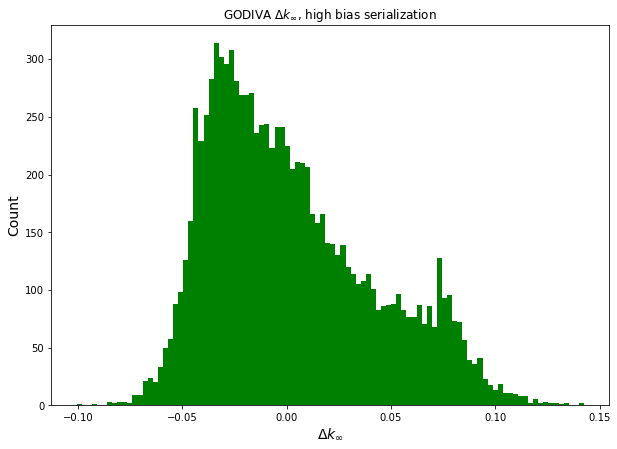

In [31]:
# Creating dataset
a = (y_predicted-y_test.T)*normConst
print(a.shape)
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a[:,0],bins=100,label="BOL",color='g')
plt.xlabel("$Δk_{\infty}$", size=14)
plt.ylabel("Count", size=14)
plt.title("GODIVA $Δk_{\infty}$, high bias serialization")
#plt.legend(loc='upper right')
plt.savefig("PICS/completeData_MAE_highres2_test_narrow_norm_12.png",bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')
# Show plot
plt.show()


In [32]:
print(np.std(y_test.T*normConst))
print(np.std(a))
print(np.mean(y_test.T*normConst))
print(np.mean(y_predicted*normConst))
print(len(y_test))
print(len(y_predicted))
print(len(a))


0.06737911895538316
0.07816604394543682
1.0796179340080996
1.0710478
9999
9999
9999


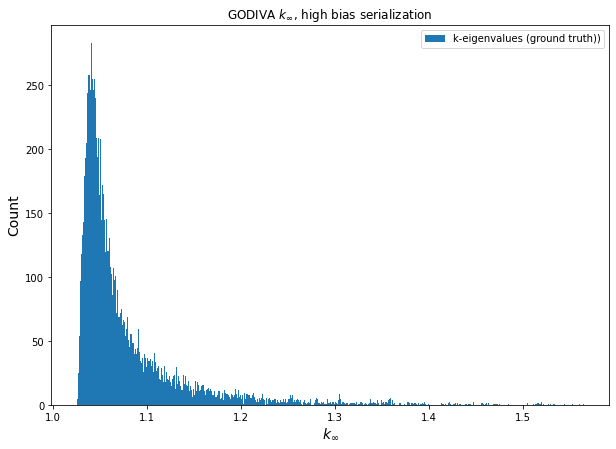

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
 

n_bins = 500
 

# Creating histogram
fig, axs = plt.subplots(figsize =(10, 7))
 
axs.hist(y_test.T*normConst, bins = n_bins,label="k-eigenvalues (ground truth))")
#axs.hist(y_predicted*normConst, bins = n_bins,label="k-eigenvalues predicted")


plt.xlabel("$k_{\infty}$", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')

plt.title("GODIVA $k_{\infty}$, high bias serialization ")
plt.savefig("PICS/kinfDist_GODIVA_MAE_highres2_test_Narrow_norm_12.png",bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')

plt.show()
# Show plot



In [34]:
np.max(y_test*normConst)-np.min(y_test*normConst)

0.540174245834351

In [35]:
np.min(y_test*normConst)

1.02492344379425

In [36]:
np.max(y_test*normConst)

1.565097689628601

In [37]:
np.sum(np.logical_and(kinf > 1.03146,kinf < 1.03546))


3279

In [38]:
np.shape(kinf)

(50000,)